# Esercitazione 11: fit di funzioni con una rete neurale

In questa esercitazione utilizzeremo del machine learning, nello specifico deep Neural Networks, per eseguire fit di funzioni a partire da dati con rumore. L'obiettivo è capire come la struttura della rete neurale influenzi la qualità del fit.

Generiamo un dataset $(x,y)$ che potrebbe essere il risultato di un processo probabilistico secondo l'equazione seguente:
$$
    y_i= f(x_i) + \eta_i,
$$
dove $f(x_i)$ rappresenta il modello che vogliamo descrivere e $\eta_i$ è il rumore gaussiano scorrelato, ovvero:
\begin{eqnarray}
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma
\end{eqnarray}
Consideriamo quindi una rete neurale in cui i parametri liberi sono rappresentati dai pesi $w$ e dai bias $h$ associati ad ogni neurone. Per definire i parametri che meglio rappresentano i dati, è necessario utilizzare un primo dataset, chiamato set di training, su cui addestrare il modello. Un secondo set, di dimensioni più ridotte, serve per testare il modello precedentemente addestrato. L'obiettivo è che la rete neurale sia in grado di generalizzare quanto appreso dai dati iniziali in nuove condizioni. Si vuole evitare l'overfitting, un fenomeno per cui la rete neurale inizia a imparare caratteristiche specifiche solo dei dati di training.

Durante l'allenamento, si minimizza una certa funzione di costo, nel nostro caso l'errore quadratico medio:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$
Il processo di ricerca del minimo può essere eseguito utilizzando diversi algoritmi: possibili scelte sono la discesa stocastica del gradiente "SGD" o l'algoritmo "Adam".



# Fit di funzione lineare con un solo neurone

Cerchiamo di effettuare il fit di una semplice funzione lineare:

$$
f(x)=2x+1
$$

Questo caso è piuttosto speciale poiché i neuroni funzionano esattamente come funzioni lineari. Considerato questo fatto, un solo strato con un solo neurone dovrebbe quindi essere sufficiente (e in un certo senso è anche la scelta migliore) per un buon fit.

In un modello di questo tipo, i parametri che possono essere modificati sono quindi tre:

1. $N_{train}$, ovvero il numero di dati di training.
2. $N_{epochs}$, ovvero il numero di epoche utilizzato per l'ottimizzazione.
3. $\sigma$, ovvero la quantità di rumore con cui vengono generati i dati iniziali.

Dalle prove effettuate, probabilmente a causa della semplicità del modello, è emerso che non è necessario aumentare i punti di training. Per questo motivo si è mantenuto $N_{train}=500$ per ogni simulazione. Per quanto riguarda i dati di test, invece, ne generiamo sempre in quantità pari a $\frac{1}{10}N_{train}$. Si è quindi proceduto a generare dati con un rumore via via crescente e ad analizzare la velocità di apprendimento della rete.

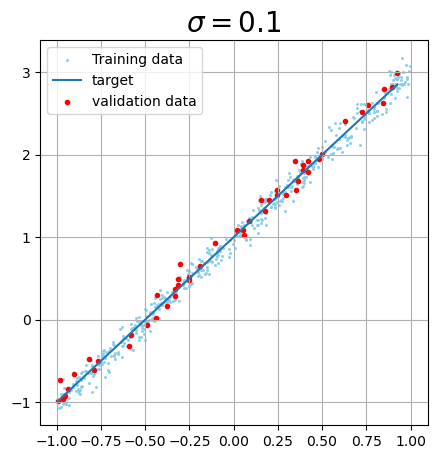

In [3]:
import numpy as np
import matplotlib.pyplot as plt


# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 500)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()

m = 2 # slope
b = 1 # intersect
y_target = m * x_valid + b # ideal (target) linear function

sigma = [0.1, 0.3, 0.5] # noise standard deviation, for the moment it is absent
sigmas= ["0.1", "0.3", "0.5"]

y_train = np.zeros((3, len(x_train)))  # Define y_train as a matrix
y_valid = np.zeros((3, len(x_valid)))  # Define y_valid as a matrix

plt.figure(figsize=(17,5))
for i in range (1):
    plt.subplot(1,3,i+1)
    y_train[i] = np.random.normal(m * x_train + b, sigma[i]) # actual measures from which we want to guess regression parameters
    y_valid[i] = np.random.normal(m * x_valid + b, sigma[i])
    plt.scatter(x_train, y_train[i], marker = ".",   label='Training data',linewidth=0.5,color='skyblue',s=10)
    plt.plot(x_valid, y_target, label='target')
    plt.scatter(x_valid, y_valid[i], color='r', label='validation data', marker=".")
    plt.title("$\sigma=$"+sigmas[i], fontsize=20)
    plt.legend()
    plt.grid(True)
      
plt.show()



In questo grafico è mostrato un confronto tra la funzione target che vogliamo fittare e i dato che utilizziamo per la validazione finale. Questi ultimi sono simili ai dati utilizzati per la calibrazione, ma sono molti meno e sono indipendenti dai essi.


Definiamo quindi la rete neurale con un solo strato ad un solo neurone. Un neurone è una sola funzione lineare $y=m~x+q$, che prende gli input $x$ e restituisce dei valori. L'ottimizzazione dei due gradi di libertà $m,~q$ è quindi raggiunta con un'algoritmo di discesa stocastica del gradiente.

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

Nepochs = 40


model = Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss, and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# create history
history = model.fit(
        x=x_train,
        y=y_train[i],
        batch_size=32,
        epochs=Nepochs,
        shuffle=True,
        validation_data=(x_valid, y_valid[i]),
        verbose=0
)
    
# evaluate model
score = model.evaluate(x_valid, y_valid[i], batch_size=32, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
    


/home/daniele/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 - mse: 0.0112 
Test loss: 0.011138425208628178
Test accuracy: 0.011138425208628178


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


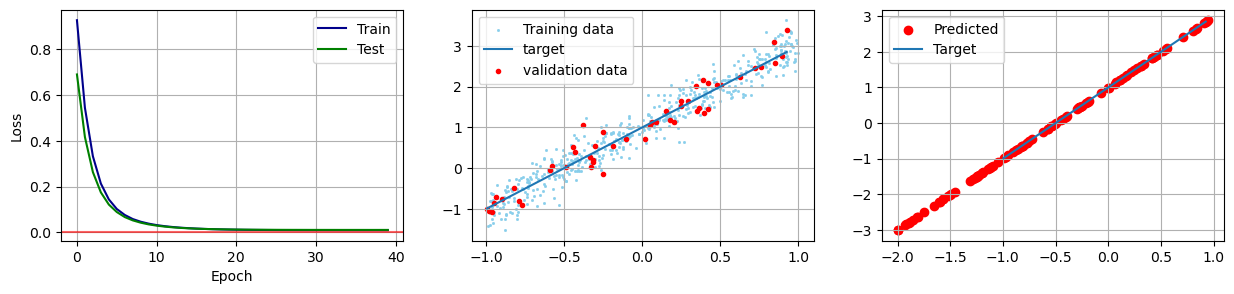

In [5]:
plt.figure(figsize=(15,3))  

plt.subplot(1,3,2)
y_train[i] = np.random.normal(m * x_train + b, 0.3) # actual measures from which we want to guess regression parameters
y_valid[i] = np.random.normal(m * x_valid + b, 0.3)
plt.scatter(x_train, y_train[i], marker = ".",   label='Training data',linewidth=0.5,color='skyblue',s=10)
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid[i], color='r', label='validation data', marker=".")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], color="darkblue")
plt.plot(history.history['val_loss'], color="green")
plt.axhline(0, color='red', alpha=0.6)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.grid(True)
    
plt.subplots_adjust(hspace=0.5)  
  
plt.subplot(1,3,3)
x_predicted = np.random.uniform(-2, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted, color='r', label='Predicted')
plt.plot(x_valid, y_target, label='Target')
plt.legend()
plt.grid(True)


plt.show()


Diminuendo il numero di dati di training sono necessarie più epoche per far convergere la rete neurale verso i parametri che minimizzano la funzione di costo.
La rete neurale approssima molto bene la curva iniziale. Questo è dovuto fondamentalmente al fatto che la scelta dell'architettura della rete neurale, dovuta a una nostra conoscenza pregressa del modello, ha vincolato l'output ad essere lineare. Notiamo che per questo motivo la rete predice molto bene anche al di fuori del dominio su cui è stata allenata.

Nel grafico a sinistra ho rappresentato l'andamento delle loss (valutate mediante la metrica scelta, <i>Mean Square Error</i>) sia sui dati di addestramento che su quelli di test, in funzione dell'epoca. In un'efficace addestramento, entrambe convergono verso un valore minimo, possibilmente con una discesa approssimativamente esponenziale. Al centro, è riproposto lo stesso grafico mostrato sopra. A destra, è presentato il grafico che mostra le predizioni del modello su un dominio più ampio rispetto a quello utilizzato per l'addestramento.

Se anche al di fuori del dominio di addestramento le previsioni sono in accordo con la legge lineare, significa che l'addestramento è stato efficace.



## Osservazioni

Con un basso numero di epoche, ad esempio 10 (il che implica un apprendimento rapido), e fissando $N_\text{train}=500$:

- Con $\sigma=0$ le previsioni sono scarse poiché la loss sui dati di test non ha ancora avuto il tempo di convergere verso quella calcolata sui dati di addestramento, né di stabilizzarsi sul valore minimo. 

- Con $\sigma=0.2$, la situazione migliora notevolmente, con previsioni più accurate. Le loss del modello convergono bene, anche perché partono da un livello di divergenza inferiore.

- Con $\sigma=0.3$, la situazione è ottima. La differenza iniziale tra le loss di test e di addestramento è minima, e diminuisce ulteriormente con l'aumentare delle epoche. In particolare, si osserva che durante le prime epoche, la loss sui dati di test supera quella di addestramento prima di stabilizzarsi su valori inferiori, coerentemente con il fatto che il modello è stato addestrato sui dati di addestramento e sta incontrando per la prima volta quelli di test.

- Con $\sigma=0.5$, entrambe le loss rimangono molto elevate e 10 epoche non sono sufficienti per un'efficace fase di addestramento del modello, il quale fornisce previsioni completamente errate.

In sintesi, maggiore è il rumore presente nei dati utilizzati per l'addestramento e il test del modello, maggiori saranno il numero di epoche necessarie affinché l'addestramento produca risultati accettabili e la capacità del modello di fare previsioni sulla retta risulti soddisfacente. In generale, le loss function diminuiscono entro una decina di epoche, e continuare l'addestramento oltre tale punto non porta a significativi miglioramenti nella capacità predittiva del modello.

Naturalmente, con $\sigma=0$, all'aumentare delle epoche, il fit tende alla perfezione. Tuttavia, bisogna fare attenzione a non sovrallenare il modello, soprattutto considerando un rumore elevato e una rete con numerosi nodi che potrebbe tendere a imparare quel rumore. In questo caso, la $\sigma$ dovrebbe essere dell'ordine del rumore o superiore, in modo da prevalere su di esso.

Aumentare il numero di punti di addestramento, come ci si poteva aspettare, comporta un'apprendimento più veloce della rete. Ad esempio, fissando $\sigma=0.2$, il valore minimo della loss del modello si raggiunge in circa $20$ epoche con $N_\text{train}=500$, mentre ne occorrono circa $10$ con $N_\text{train}=1000$. In generale, può essere più conveniente investire sull'addestramento piuttosto che sul numero di epoche, poiché in casi come questo, il tempo di addestramento aumenta maggiormente con il numero di epoche rispetto al numero di dati di addestramento.



# Fit di funzione cubica

Estendiamo ora il modello in modo da produrre un fit della seguente cubica:

$$
f(x)=4-3x-2x^2+3x^3
$$
con $x \in [-1,1]$.

In questo caso la funzione da fittare non è lineare, quindi non basta un solo neurone in un solo strato. In base all'esercizio precedente si è scelto di fissare $\sigma = 0.2$. Mostriamo i dati di training e di test e poi i risultati ottenuti con diverse architetture della rete neurale.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return a + b*x + c*x**2 + d*x**3

# parameters of f(x) = a+bx+cx^2+dx^3
a = 4 
b = -2 
c = -3
d = 3

# generate training inputs
Ntrain=3000
Nepochs=30
sigma=0.2

np.random.seed(0)
x_train = np.random.uniform(-1, 1, Ntrain)
x_valid = np.random.uniform(-1, 1, 300)
x_valid.sort()
y_target = f(x_valid) # ideal (target) polynomial

y_train = np.zeros((3, len(x_train)))  # Define y_train as a matrix
y_valid = np.zeros((3, len(x_valid)))  # Define y_valid as a matrix

for i in range (3):
    y_train[i] = np.random.normal(f(x_train), sigma) # actual measures from which we want to guess regression parameters
    y_valid[i] = np.random.normal(f(x_valid), sigma)

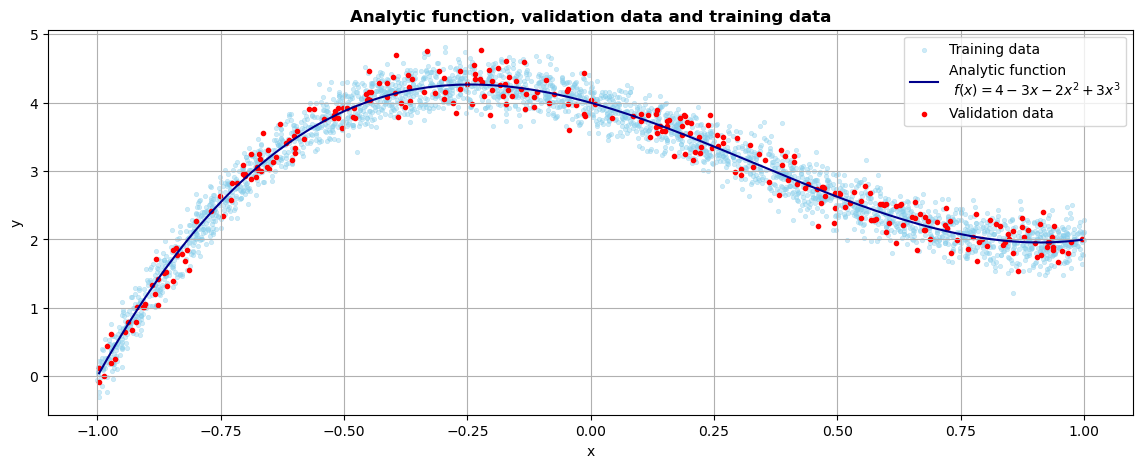

In [7]:
plt.figure(figsize=(14,5))
plt.scatter(x_train, y_train[0], color='skyblue',s=10, label='Training data',linewidth=0.5, alpha=0.4)
plt.plot(x_valid, y_target, label = "Analytic function\n $f(x) = 4 - 3x - 2x^2 + 3x^3$", color="darkblue")
plt.scatter(x_valid, y_valid[0], marker = ".", color='r', label='Validation data')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytic function, validation data and training data", fontweight = "bold")
plt.grid()
plt.legend()
plt.show()

Mando l'input $x$ in 20 diverse funzioni lineari (ho quindi 40 gradi di libertà per questo primo livello della funzione), aggiungendo un rettificatore, che è una funzione non lineare, necessaria dato che vogliamo fittare una funzione non lineare. Ripeto questo passaggio, passando i risultati in altre 30 funzioni lineari e in un rettificatore. Infine mando tutti i risultati in una singola funzione lineare, dato che il risultato dev'essere un singolo numero. 
<img src="ml.png">

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
i=2
Nepochs = 40

model = Sequential()
    
act = 'relu'
# applico funzione nonlineare relu all'input x
# per dare mx+q (cerco 40 parametri)
model.add(Dense(20, input_shape=(1,), activation = act))
if (i>0):
    model.add(Dense(30, activation = act))
if (i>1):
    model.add(Dense(30, activation = act))
model.add(Dense(1, activation = 'relu'))

# compile the model choosing optimizer, loss, and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# create history
history = model.fit(
        x=x_train,
        y=y_train[i],
        batch_size=32,
        epochs=Nepochs,
        shuffle=True,
        validation_data=(x_valid, y_valid[i]),
        verbose=0
)
    
# evaluate model
score = model.evaluate(x_valid, y_valid[i], batch_size=32, verbose=1)
print('Test loss:', score[0])
    



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.0532 - mse: 0.0532
Test loss: 0.04676778241991997


<Figure size 1400x1000 with 0 Axes>

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


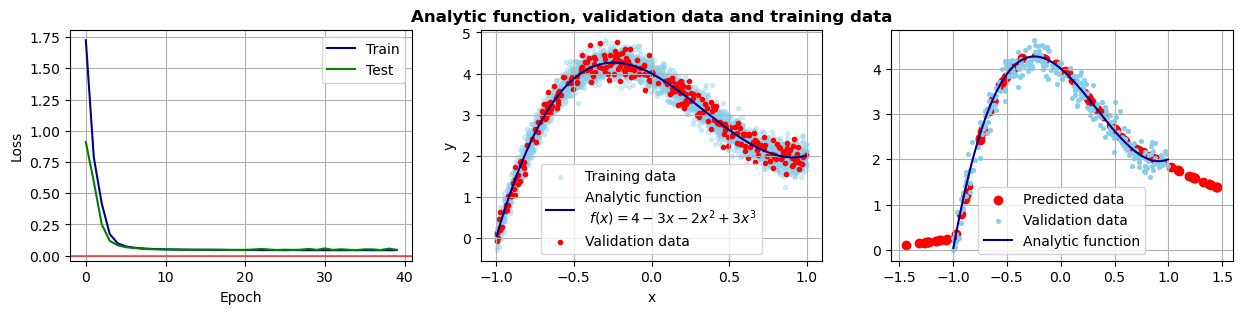

In [21]:
plt.figure(figsize=(15,3))  

plt.subplot(1,3,1)

plt.plot(history.history['loss'], color="darkblue")
plt.plot(history.history['val_loss'], color="green")
plt.axhline(0, color='red', alpha=0.6)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.grid(True)
    

plt.subplot(1,3,2)
plt.scatter(x_train, y_train[0], color='skyblue',s=10, label='Training data',linewidth=0.5, alpha=0.4)
plt.plot(x_valid, y_target, label = "Analytic function\n $f(x) = 4 - 3x - 2x^2 + 3x^3$", color="darkblue")
plt.scatter(x_valid, y_valid[0], marker = ".", color='r', label='Validation data')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytic function, validation data and training data", fontweight = "bold")
plt.grid()
plt.legend()


plt.subplot(1,3,3)
x_predicted = np.random.uniform(-1.5, 1.5, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label='Predicted data')
plt.scatter(x_valid, y_valid[i], color='skyblue',s=10, label='Validation data', linewidth=0.5)
plt.plot(x_valid, f(x_valid), label='Analytic function', color="darkblue")
plt.legend()
plt.grid(True)


plt.subplots_adjust(hspace=0.5)  
plt.show()


Il miglior risultato si ottiene con tre strati. Riducendo il numero di strati, il tempo di convergenza aumenta, mentre con quattro strati, il tempo di convergenza sembra leggermente inferiore rispetto a quello di tre strati, ma con un costo più elevato. Quindi, tre strati sembrano essere sufficienti per l'addestramento.

Al contrario, provando ad avere solo due strati aumentando però il numero di neuroni nel primo strato, non si è verificato un grande miglioramento. Invece, un miglioramento sostanziale si trova aumentando la profondità della rete. Per quanto riguarda i metodi di ottimizzazione, non sembrano esservi vantaggi significativi nell'uso di uno o dell'altro.

Con tre strati con tutti questi parametri liberi, dovrei avere abbastanza parametri per effettuare il fit. Nell'apprendimento automatico, i parametri devono essere in numero molto maggiore rispetto ai punti da fittare. Non devono essere però troppi, in modo da evitare sovradattamento.

Vediamo che in questo caso, a differenza della funzione lineare, con questi metodi non c'è alcuna speranza di modellizzare la funzione al di fuori del dominio in cui la rete è stata allenata.




# Fit di funzione di più variabili

Estendiamo il modello per il fit di una funzione 2D come $f(x,y) = \sin(x^2+y^2)$ nel range $x \in [-3/2,3/2]$ e $y \in [-3/2,3/2]$.

Mostriamo la funzione e i punti di training e di test:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def f(x,y):
    return np.sin(x**2+y**2)


# generate training inputs
Ntrain=10000
Nepochs=30
Nvalidation = int(Ntrain/10)
#Nvalidation = 1000
sigma=0.2

np.random.seed(0)
span=3/2

x_train = np.random.uniform(-span, span, Ntrain)
y_train = np.random.uniform(-span, span, Ntrain)

x_valid = np.random.uniform(-span, span, Nvalidation)
y_valid = np.random.uniform(-span, span, Nvalidation)

XY_train = np.column_stack((x_train,y_train))      # in the format needed
XY_valid = np.column_stack((x_valid,y_valid))      #   by `model.fit` method

z_train = np.random.normal(f(x_train,y_train), sigma) 
z_valid = np.random.normal(f(x_valid,y_valid), sigma)

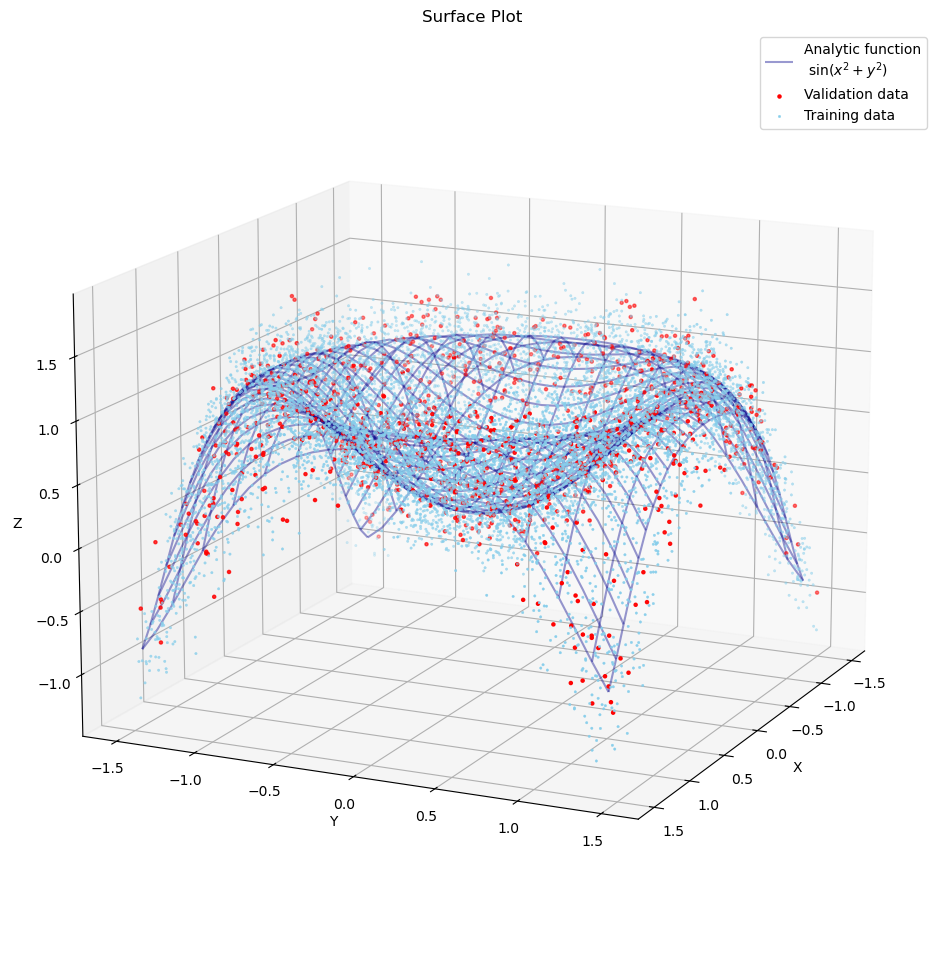

In [23]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

x_ = np.arange(-span,span, 0.1)
y_ = np.arange(-span,span, 0.1)
X_, Y_ = np.meshgrid(x_,y_)
ax.plot_wireframe(  X_, Y_, f(X_,Y_), 
                    rstride=2, label='Analytic function\n $\sin(x^2+y^2)$', color = 'darkblue',
                    alpha =0.4)

ax.scatter(x_valid, y_valid, z_valid, marker = ".", color = "r", label='Validation data')
ax.scatter(x_train, y_train, z_train, color='skyblue',s=3,
               label='Training data', linewidth=0.3)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Plot')
ax.view_init(elev=15, azim=25) 
plt.legend()
plt.show()

In questo caso, essendo in presenza di un problema più complesso caratterizzato da uno spazio dei parametri a maggiore dimensionalità, possiamo aspettarci la necessità di aumentare la complessità della rete neurale aumentando neuroni e strati. Ho fatto un po' di prove e quattro strati con un buon numero di neuroni nei primi sembra garantire un ottimo fit.

In [24]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()

act = 'tanh'
model.add(Dense(40, input_shape=(2,), activation = act)) #160 param liberi
model.add(Dense(30, activation = act))
model.add(Dense(20, activation = act))
# un solo neurone poiché ho un output scalare
model.add(Dense(1, activation = act))


# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='nadam', loss='mse', metrics=['mse'])

In [25]:
history = model.fit(x=XY_train, y=z_train, 
          batch_size=32, epochs=Nepochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(XY_valid, z_valid),verbose=0)

In [26]:
# evaluate model
score = model.evaluate(XY_valid, z_valid, batch_size=32, verbose=0)
#verbose=1: It controls the verbosity mode. In this case, verbose=1 means that the evaluation 
#progress and results will be displayed during the evaluation.

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.04231644049286842
Test accuracy: 0.04231644049286842


In [27]:
# generate predictions
x_predicted = np.random.uniform(-span, span, 2000) 
y_predicted = np.random.uniform(-span, span, 2000) 
XY_predicted = np.column_stack((x_predicted,y_predicted))
z_predicted = model.predict(XY_predicted)

# plot
x_ = np.arange(-span,span, 0.1)
y_ = np.arange(-span,span, 0.1)
X_, Y_ = np.meshgrid(x_,y_)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


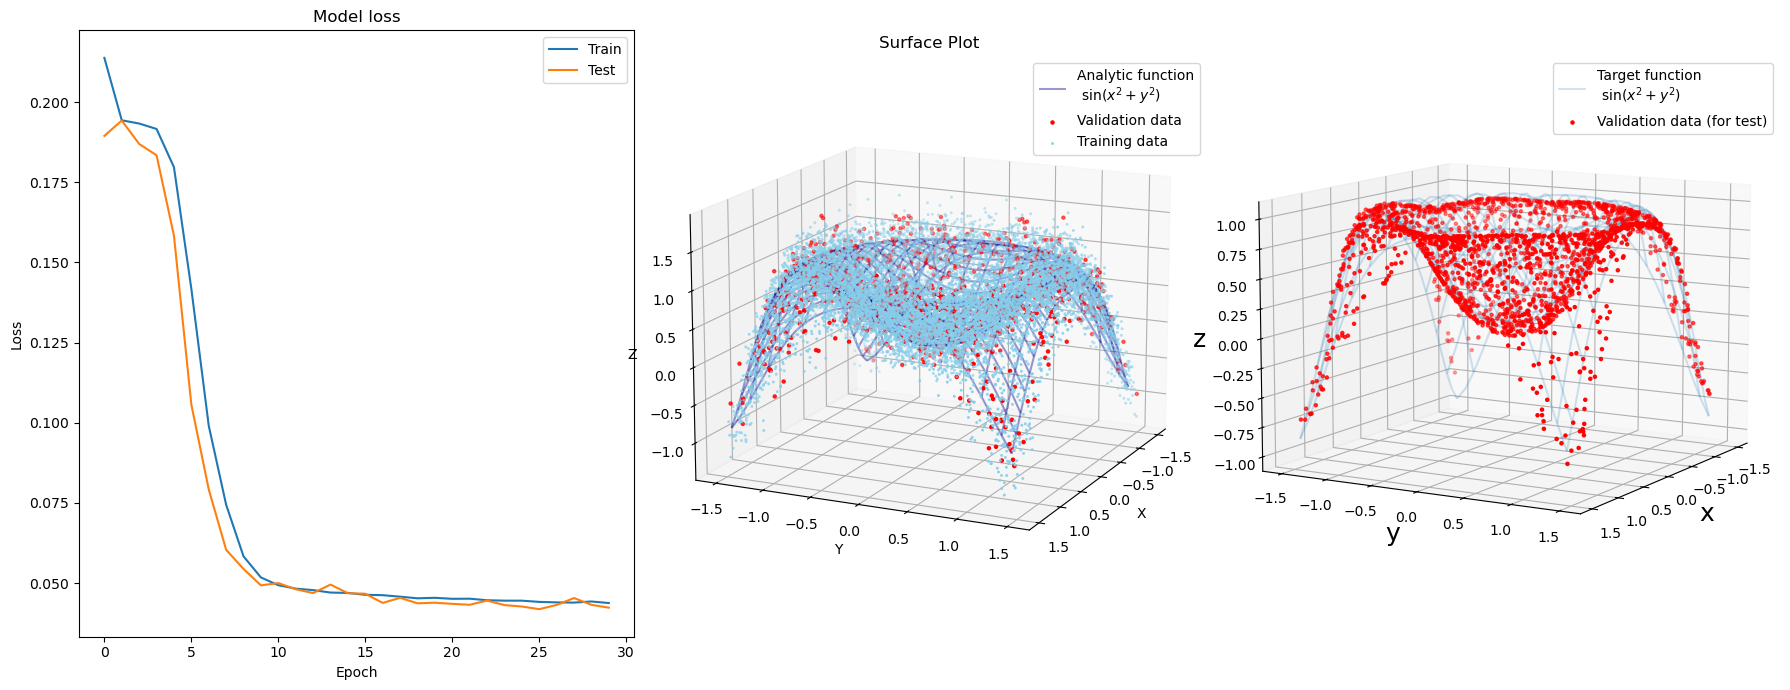

In [28]:
# look into training history
# Plot training & validation loss values
fig = plt.figure(figsize=(18, 7))  # Increase the figure size

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

#------------------------------------------------------------
ax = fig.add_subplot(1, 3, 2, projection='3d')  # Adjust the size of the second subplot
x_ = np.arange(-span, span, 0.1)
y_ = np.arange(-span, span, 0.1)
X_, Y_ = np.meshgrid(x_, y_)
ax.plot_wireframe(X_, Y_, f(X_, Y_), rstride=2, label='Analytic function\n $\sin(x^2+y^2)$', color='darkblue',
                  alpha=0.4)
ax.scatter(x_valid, y_valid, z_valid, marker=".", color="r", label='Validation data')
ax.scatter(x_train, y_train, z_train, color='skyblue', s=3,
           label='Training data', linewidth=0.3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Plot')
ax.view_init(elev=15, azim=25)
plt.legend()

#------------------------------------------------------------

ax = fig.add_subplot(1, 3, 3, projection='3d')  # Adjust the size of the third subplot
x_ = np.arange(-span, span, 0.1)
y_ = np.arange(-span, span, 0.1)
X_, Y_ = np.meshgrid(x_, y_)
ax.plot_wireframe(X_, Y_, f(X_, Y_), rstride=2, cstride=2,
                  label='Target function\n $\sin(x^2+y^2)$',
                  alpha=0.2)
ax.scatter(x_predicted, y_predicted, z_predicted, marker=".", color="r", label='Validation data (for test)')
ax.set_xlabel("x", fontsize=18)
ax.set_ylabel("y", fontsize=18)
ax.set_zlabel("z", fontsize=18)
ax.legend()
ax.view_init(10, 30)

plt.tight_layout()  # Adjust subplots to avoid overlapping
plt.show()

Notiamo che per questo problema servono più generazioni perché i pesi e i bias si stabilizzino. Questo comportamento era prevedibile a causa della maggiore complessità del problema.

Notiamo un ottimo fit su tutto il dominio di allenamento. Il maggiore problema è quello di avere un buon fit sulle code. Si nota che aumentare gli strati, il numero di neuroni e il numero delle epoche non migliora molto questo aspetto. L'unico modo efficace è impostare l'ottimizzatore su "nadam" o "adam". Probabilmente la difficoltà è dovuta al fatto che abbiamo una densità di dati molto bassa sulle code della funzione.